# DIP Homework 2

In [36]:
import argparse
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os.path as osp

## Read / write image

In [37]:
def read_image(path):
    print("read image:", path)
    img_bgr = cv2.imread(path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb
    

def write_image(path, img):
    print("write image:", path)
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, img_bgr)

## Histogram specification

In [46]:
def histogram_specification(src_img, tar_img=None):
    # get the histogram of source image (normalized to sum = 1)
    src_hist, index = np.histogram(src_img, bins=range(256 + 1), density=True)  

    # get source cdf of histogram
    src_cdf = np.cumsum(src_hist)

    # define target cdf
    if tar_img:
        tar_hist, index = np.histogram(tar_img, bins=range(256 + 1), density=True)
        tar_cdf = np.cumsum(tar_hist)
        
    else:
        # histogram equalization
        tar_hist = np.ones(256) / 256
        tar_cdf = np.linspace(0, 1, 256)

    # init mapping
    mapping = np.zeros(256, dtype=np.uint8)

    # find mapping
    index = index[:-1]

    for i in index:
        min_diff = 1.0

        for j in range(mapping[i-1], 256):  # continue finding mapping from last found mapping (i-1)
            diff = np.abs(src_cdf[i] - tar_cdf[j])  # find the closest diff

            if diff <= min_diff:  # recording closer diff until its the closest
                min_diff = diff
                mapping[i] = j

            else:  # if closest diff found, break the inner loop
                break
    
    # map pixel values
    res_img = mapping[src_img]
    res_hist, index = np.histogram(res_img, bins=range(256 + 1), density=True)
    res_cdf = np.cumsum(res_hist)
    
    return [src_img, res_img], [src_hist, res_hist], [src_cdf, res_cdf]

## Display result

In [47]:
def plot_result(plots, save_path):    
    # init graph
    nrows, ncols, size = 2, 3, 7.5
    fsize = (ncols * size, nrows * size)  # figure size: (w, h)
    fig, ax = plt.subplots(nrows, ncols, figsize=fsize)
    xticks = np.linspace(0, 256, 9)
    
    if plots.cspace == "gray":
        # display images
        ax[0, 0].imshow(plots.src.img, cmap="gray")
        ax[1, 0].imshow(plots.res.img, cmap="gray")
        
        # display histograms
        ax[0, 1].plot(plots.src.hists[0])
        ax[1, 1].plot(plots.res.hists[0])
        
        # display cdfs
        ax[0, 2].bar(range(256), plots.src.cdfs[0], width=1.0)
        ax[1, 2].bar(range(256), plots.res.cdfs[0], width=1.0)
    
    elif plots.cspace == "rgb":
        colors = ["C3", "C2", "C0"]
        
        # display images
        ax[0, 0].imshow(plots.src.img)
        ax[1, 0].imshow(plots.res.img)
        
        # display histograms
        for c in range(3):
            ax[0, 1].plot(plots.src.hists[c], color=colors[c])
            ax[1, 1].plot(plots.res.hists[c], color=colors[c])
            
        # display cdfs
        for c in range(3):
            ax[0, 2].plot(plots.src.cdfs[c], color=colors[c])
            ax[1, 2].plot(plots.res.cdfs[c], color=colors[c])
            
    elif plots.cspace == "yuv":
        # display images
        ax[0, 0].imshow(plots.src.img)
        ax[1, 0].imshow(plots.res.img)
        
        # display histograms
        ax[0, 1].plot(plots.src.hists[0])
        ax[1, 1].plot(plots.res.hists[0])
        
        # display cdfs
        ax[0, 2].bar(range(256), plots.src.cdfs[0], width=1.0)
        ax[1, 2].bar(range(256), plots.res.cdfs[0], width=1.0)
    
    # plot styles
    plt.setp(ax[0, 0], title="source (%s)" % plots.cspace, xticks=[], yticks=[])
    plt.setp(ax[1, 0], title="result (%s)" % plots.cspace, xticks=[], yticks=[])

    ax[0, 1].grid(linestyle=':')
    ax[1, 1].grid(linestyle=':')
    plt.setp(ax[0, 1], title="source histogram (%s)" % plots.cspace, xticks=xticks)
    plt.setp(ax[1, 1], title="result histogram (%s)" % plots.cspace, xticks=xticks)
    
    ax[0, 2].grid(linestyle=':')
    ax[1, 2].grid(linestyle=':')
    plt.setp(ax[0, 2], title="source cdf (%s)" % plots.cspace, xticks=xticks)
    plt.setp(ax[1, 2], title="result cdf (%s)" % plots.cspace, xticks=xticks)
    
    # adjust margin
    plt.subplots_adjust(
        left=0.03,
        right=0.97,
        top=0.95,
        bottom=0.05,
        wspace=0.1,
        hspace=0.1
    )
    
    # save result
    fig.savefig(save_path)
    
    # display result
    fig.show()

In [48]:
parser = argparse.ArgumentParser("Image Histogram Specification")
parser.add_argument("source", type=str, default="imgs/selfie.jpg", help="source image path")
parser.add_argument("--target", type=str, default=None, help="target image path. if none, the target will be "
                                                             "equalized histogram")
parser.add_argument("--cspace", type=str, default="gray", choices=["gray", "rgb", "yuv"], help="color space used")
parser.add_argument("--plot", default=False, action="store_true", help="plot histograms")

_StoreTrueAction(option_strings=['--plot'], dest='plot', nargs=0, const=True, default=False, type=None, choices=None, help='plot histograms', metavar=None)

read image: imgs/selfie.jpg
write image: imgs/selfie-gray-src.jpg
write image: imgs/selfie-gray-res.jpg


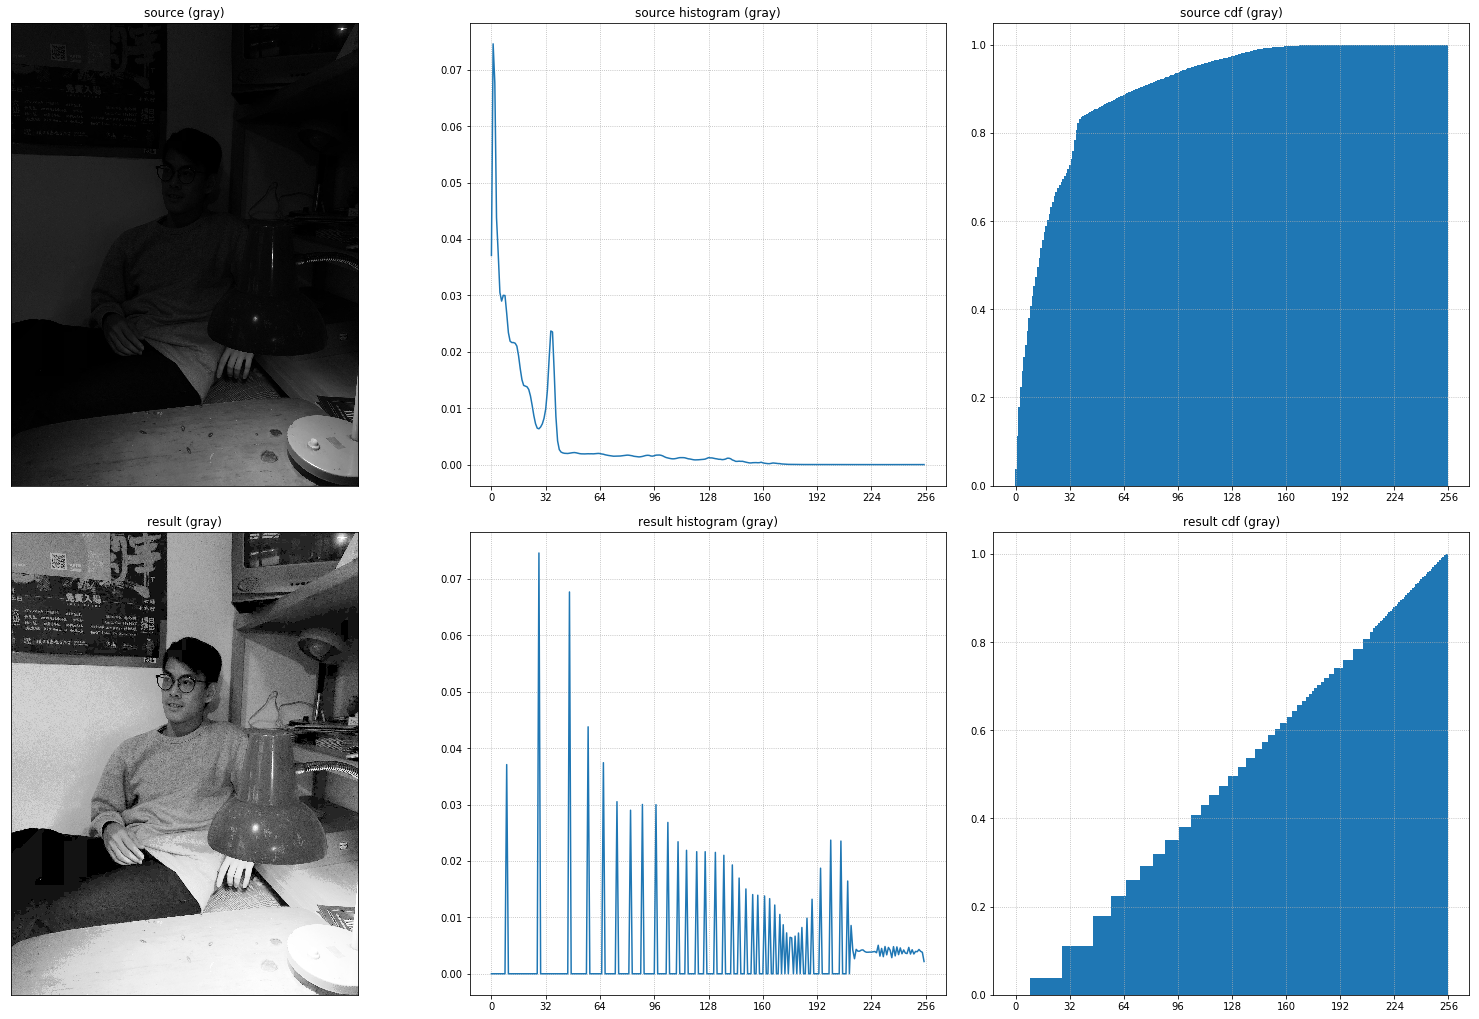

In [50]:
class Graphset:
    
    def __init__(self):
        self.img = None
        self.hists = []
        self.cdfs = []
    

class PlotInfo:
    
    def __init__(self, cspace="gray"):
        self.cspace = cspace
        self.src = Graphset()
        self.res = Graphset()


def main(args):
    name, ext = osp.splitext(args.source)
    src_save_path = name + "-%s-src" % args.cspace + ext
    res_save_path = name + "-%s-res" % args.cspace + ext
    hist_save_path = name + "-%s-hist" % args.cspace + ext
    
    src_rgb = read_image(args.source)
    tar_rgb = read_image(args.target) if args.target else None
    
    plots = PlotInfo(args.cspace)
    
    if args.cspace == "gray":
        # convert color space to gray
        src_gray = cv2.cvtColor(src_rgb, cv2.COLOR_RGB2GRAY)
        tar_gray = cv2.cvtColor(tar_rgb, cv2.COLOR_RGB2GRAY) if tar_rgb else None
        
        # histogram equalization or specification
        imgs, hists, cdfs = histogram_specification(src_gray, tar_gray)
        
        # save source and result images
        write_image(src_save_path, imgs[0])
        write_image(res_save_path, imgs[1])
        
        # save histograms
        if args.plot:
            plots.src.img = imgs[0]
            plots.src.hists += [hists[0]]
            plots.src.cdfs += [cdfs[0]]
            plots.res.img = imgs[1]
            plots.res.hists += [hists[1]]
            plots.res.cdfs += [cdfs[1]]
            plot_result(plots, hist_save_path)
            
    elif args.cspace == "rgb":
        height, width, channels = src_rgb.shape
        res_rgb = np.zeros(src_rgb.shape, dtype=np.uint8)
        
        for c in range(channels):
            src_img = src_rgb[:, :, c]
            tar_img = tar_rgb[:, :, c] if tar_rgb else None
            
            # histogram equalization or specification
            imgs, hists, cdfs = histogram_specification(src_img, tar_img)
            
            # apply new values on channel
            res_rgb[:, :, c] = imgs[1]
            
            if args.plot:
                plots.src.hists += [hists[0]]
                plots.src.cdfs += [cdfs[0]]
                plots.res.hists += [hists[1]]
                plots.res.cdfs += [cdfs[1]]
                
        # save source and result images
        write_image(src_save_path, src_rgb)
        write_image(res_save_path, res_rgb)
        
        if args.plot:
            plots.src.img = src_rgb
            plots.res.img = res_rgb
            plot_result(plots, hist_save_path)
            
    elif args.cspace == "yuv":
        height, width, channels = src_rgb.shape
        
        # convert color space to yuv
        src_yuv = cv2.cvtColor(src_rgb, cv2.COLOR_RGB2YUV)
        tar_yuv = cv2.cvtColor(tar_rgb, cv2.COLOR_RGB2YUV) if tar_rgb else None
        
        # init result image
        res_yuv = np.zeros(src_rgb.shape, dtype=np.uint8)
        res_yuv[:, :, 1] = src_yuv[:, :, 1]
        res_yuv[:, :, 2] = src_yuv[:, :, 2]
        
        # extract y channel
        src_y = src_yuv[:, :, 0]
        tar_y = tar_yuv[:, :, 0] if tar_yuv else None
        
        # histogram equalization or specification
        imgs, hists, cdfs = histogram_specification(src_y, tar_y)
        
        # apply new values on y channel
        res_yuv[:, :, 0] = imgs[1]
        
        # convert color space back to rgb
        res_rgb = cv2.cvtColor(res_yuv, cv2.COLOR_YUV2RGB)
        
        # save source and result image
        write_image(src_save_path, src_rgb)
        write_image(res_save_path, res_rgb)
        
        if args.plot:
            plots.src.img = src_rgb
            plots.src.hists += [hists[0]]
            plots.src.cdfs += [cdfs[0]]
            plots.res.img = res_rgb
            plots.res.hists += [hists[1]]
            plots.res.cdfs += [cdfs[1]]
            plot_result(plots, hist_save_path)


if __name__ == '__main__':
    args = parser.parse_args([
        "imgs/selfie.jpg",
        "--plot",
        "--cspace", "gray"
    ])
    main(args)
